Author: V. Cottet
Date: 02/06/2015

This notebook aims at doing Matrix completion under Quantile Loss with Nuclear norm penalization. The program is:
$$ 
\widehat{M} = \textrm{arg}\min_M \frac{1}{N} \sum_{i=1}^{N} \left(\tau (Y_i-M_{X_i})_+ + (1-\tau)(M_{X_i}-Y_i)_+ \right) + \mu ||M||_{S_1} \tag{QN}
$$

The first part is to create the examples, the second is the main function by ADMM with parameters (Y_obs,indices, tau, mu,rho, tol), rho and tol are parameters required by the optimization method.

# Section 1: Matrix creation

Initialization 

In [85]:
# Init the prog
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cvx
from scipy.sparse.linalg import svds   # Fast SVD for sparse matrix using ARPACK Fortran routines
from __future__ import division
%matplotlib inline

np.random.seed(1000)

# Init the general parameters
rank = 3
m1 = 200
m2 = 200
rate = .2
n = int(m1*m2*rate)

# Define the test functions
def SquaredLossTot(Y,M):
    result = np.mean((Y-M)**2)
    return(result)

def AbsLossTot(Y,M):
    result = np.mean(abs(Y-M))
    return(result)

def SquaredLossTest(Yobs,M,indices):
    result = np.mean((Yobs-M.flat[indices])**2)
    return(result)

def AbsLossTest(Yobs,M,indices):
    result = np.mean(abs(Yobs-M.flat[indices]))
    return(result)

In [86]:
# Matrix Creation Functions
# Type A: Gaussian noise 
def AbsMatrixCreationA(m1,m2,rank,n,lnoise):
    L = np.random.normal(0,1,size=(m1,rank))
    R = np.random.normal(0,1,size=(rank,m2))
    Y = np.dot(L,R)
    indices = np.random.choice(m1*m2,n)
    Yobs = Y.flat[indices] + np.sqrt(lnoise)*np.random.normal(0,1,size=n)    
    return(Y,Yobs,indices)

# Type B: Student noise, df to be chosen
def AbsMatrixCreationB(m1,m2,rank,n,lnoise,df):
    L = np.random.normal(0,1,size=(m1,rank))
    R = np.random.normal(0,1,size=(rank,m2))
    Y = np.dot(L,R)
    indices = np.random.choice(m1*m2,n)
    Yobs = Y.flat[indices] + np.sqrt(lnoise)*np.random.standard_t(df=df,size=n)    
    return(Y,Yobs,indices)

# Type C: Gaussian noise with outliers (about 10 shift)
def AbsMatrixCreationC(m1,m2,rank,n,lnoise,pct_outlier):
    L = np.random.normal(0,1,size=(m1,rank))
    R = np.random.normal(0,1,size=(rank,m2))
    Y = np.dot(L,R)
    indices = np.random.choice(m1*m2,n)
    outlier = np.random.binomial(1,pct_outlier,n)
    sign = 2*np.random.binomial(1,.5,n)-1
    Yobs = Y.flat[indices] + np.sqrt(lnoise)*np.random.normal(0,1,n)+outlier*sign*10    
    return(Y,Yobs,indices)


(array([  1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          4.00000000e+00,   9.00000000e+00,   2.70000000e+01,
          9.60000000e+01,   3.17000000e+02,   7.55000000e+02,
          2.09400000e+03,   5.15600000e+03,   1.09200000e+04,
          1.14730000e+04,   5.61900000e+03,   2.22700000e+03,
          8.40000000e+02,   3.12000000e+02,   1.05000000e+02,
          3.00000000e+01,   1.30000000e+01]),
 array([-13.35607568, -12.24778839, -11.1395011 , -10.03121381,
         -8.92292652,  -7.81463924,  -6.70635195,  -5.59806466,
         -4.48977737,  -3.38149008,  -2.27320279,  -1.1649155 ,
         -0.05662821,   1.05165907,   2.15994636,   3.26823365,
          4.37652094,   5.48480823,   6.59309552,   7.70138281,   8.80967009]),
 <a list of 20 Patch objects>)

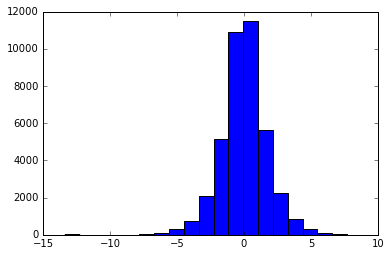

In [87]:
# Test
[Y1,Yobs1,indices1]=AbsMatrixCreationA(m1,m2,rank,n,0)
[Y2,Yobs2,indices2]=AbsMatrixCreationB(m1,m2,rank,n,1,3)
[Y3,Yobs3,indices3]=AbsMatrixCreationC(m1,m2,rank,n,1,.2)
plt.hist(np.reshape(Y1,m1*m2,1),20)

# Section 2: Quantile Completion Functions
## Section 2.1: SDP Algorithm

By introducing Slack Variables, the (QN) problem is equivalent to:
\begin{eqnarray}
\left(\hat{X},\hat{Z},\hat{U},\hat{V} \right) =
& \textrm{argmin}  &\frac{1}{N}\sum (X_i+Z_i) + \mu\frac{\textrm{Tr}(U) + \textrm{Tr}(V)}{2}\\
                        & \textrm{subject to:} &\left[ \begin{array} UU & M \\
                                               M^\top & V \end{array} \right] \succeq 0 \\
                                               && X_i \geq 0 \wedge \tau(Y_i-M_{X_i}) \\
                                               && Z_i \geq 0 \wedge (1-\tau)(M_{X_i}-Y_i) \tag{SDP}
\end{eqnarray}

Actually, the solver does it by itself so we just had the slack variables and therefore the problem (QN) is equivalent to:
\begin{eqnarray}
\left(\hat{X},\hat{Z},\hat{M} \right) =
& \textrm{argmin}  &\frac{1}{N}\sum (X_i+Z_i) + \mu||M||_{S_1}\\
                        & \textrm{subject to:} & X_i \geq 0 \wedge \tau(Y_i-M_{X_i}) \\
                                               && Z_i \geq 0 \wedge (1-\tau)(M_{X_i}-Y_i) \tag{Slack}
\end{eqnarray}

In [ ]:
def QuantileMatCompletionSDP(Yobs,indices,m1,m2,tau,mu):
    n = len(Yobs)
    X = cvx.Variable(n)
    Z = cvx.Variable(n)
    M = cvx.Variable(m1,m2)
    constr1 = (X >= 0)
    constr2 = (Z >= 0)
    constr3 = (X - tau*(Yobs-cvx.vec(M.T)[indices]) >= 0)
    constr4 = (Z - (1-tau)*(cvx.vec(M.T)[indices]-Yobs) >= 0)
    obj = cvx.Minimize(sum(X)+sum(Z)+mu*cvx.norm(M,'nuc'))

    prob = cvx.Problem(obj,[constr1,constr2,constr3,constr4])
    prob.solve(solver="SCS")
    return(np.array(M.value))

[Y4,Yobs4,indices4]=AbsMatrixCreationA(20,20,2,200,0)

In [ ]:
A = QuantileMatCompletionSDP(Yobs4,indices4,20,20,.5,3)
plt.plot(np.linalg.svd(A)[1])

In [ ]:
A_sdp = QuantileMatCompletionSDP(Yobs1,indices1,200,200,.5,4)

In [ ]:
print(SquaredLossTest(Yobs1,A_sdp,indices1), SquaredLossTot(Y1,A_sdp), AbsLossTest(Yobs1,A_sdp,indices1), AbsLossTot(Y1,A_sdp))
print("la norme nucléaire est : ")
print(sum(np.linalg.svd(A_sdp)[1]))
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.hist(np.reshape(abs(Y1-A_sdp),m1*m2,1), 20, lw=2)
plt.title("Distribution of the gaps")
plt.subplot(1,2,2)
plt.plot(np.linalg.svd(A_sdp)[1][0:11], lw=2)
plt.title("10 first Singular values of M")
plt.xlim([-2, 12])

In [ ]:
A2_sdp = QuantileMatCompletionSDP(Yobs1,indices1,200,200,.5,5)

In [ ]:
print(SquaredLossTest(Yobs1,A2_sdp,indices1), SquaredLossTot(Y1,A2_sdp), AbsLossTest(Yobs1,A2_sdp,indices1), AbsLossTot(Y1,A2_sdp))
print("la norme nucléaire est : ")
print(sum(np.linalg.svd(A2_sdp)[1]))

## Section 2.2: ADMM Algorithm

The ADMM Algorithm is used with the following program:
$$ 
\min f(M) + g(N) \\
\textrm{s.c.} M=N
$$

The updates are then:
$$
M^k = \textrm{argmin}_M  \quad f(M) + \frac{\rho}{2} ||M-N^{k-1}+U^{k-1}||^2_F =\textrm{prox}_{f/\rho} (N^{k-1}-U^{k-1}) \\
N^k = \textrm{argmin}_N \quad g(N) + \frac{\rho}{2} ||M^k-N+U^{k-1}||^2_F =\textrm{prox}_{g/\rho} (M^k+U^{k-1})\\
U^k = U^{k-1} + M^k-N^k 
$$

Here $g(N) = \mu ||N||_{S_1}$ and $f(M)=\frac{1}{N} \sum_{i=1}^{N} \left(\tau (Y_i-M_{X_i})_+ + (1-\tau)(M_{X_i}-Y_i)_+ \right)$. $\textrm{prox}_{g/\rho}$ corresponds to the soft-thresholding of the singular values with parameter $\mu/\rho$. 


In [88]:
def QuantileMatCompletionADMM(Yobs, indices, m1,m2, tau, mu, rho,tol,itermax=1000):
    n = len(Yobs)
    M = np.random.normal(0,1,size=(m1,m2))
    N = np.zeros((m1,m2))
    U = np.zeros((m1,m2))
    
    # All the variables to float type:
    mu = float(mu) ; rho = float(rho)
    
    if n != len(indices): print("There is a big Problem, check Yobs and indices")
    
    # function to evaluate the minimum of:
    # tau(y-x)_+ + (1-tau)(x-y)_+ + r/2(x-b)^2
    # w.r.t x
        
    def min_abs(y,b):
        x1 = np.minimum(y,b+tau/rho)
        x2 = np.maximum(y,b-(1-tau)/rho)
        y1 = tau*(y-x1) + rho/2 * (x1-b)**2
        y2 = (1-tau)*(x2-y) + rho/2*(x2-b)**2
        ind_min = np.where(y1<y2,x1,x2)
        return(ind_min)
    
    def update_M(N,U):
        M = N-U
        b = M.flat[indices]
        M.flat[indices] = min_abs(Yobs,b)
        return(M)
    
    def SoftThresMat(A,x):
        u,S,v = np.linalg.svd(A)
        j = S <= x
        S[j] = 0
        j = S > x
        S[j] = S[j] - x
        l=sum(j)
        return(np.dot(u[:,:l],np.dot(np.diag(S[:l]),v[:l,:])))
    
    def update_N(M,U):
        return(SoftThresMat(M+U,mu/rho))
        
    def update_U(M,N,U):
        return(U + M -N)
    
    # Main Loop
    
    ec = 1000.
    k = 0
    while(ec>tol and k<itermax):
        k = k+1
        oldM = M
        oldU = U
        # Order is arbitrary, we use this order because of the nullity of many coefficients of U.
        N = update_N(M,U)
        M = update_M(N,U)
        U = update_U(M,N,U)
        # print(sum(np.linalg.svd(N)[1]));print(sum(np.linalg.svd(M+U)[1]))
        
        ecM = np.max(abs(M-oldM))
        ecU = np.max(abs(U-oldU))
        ec=ecM+ecU
        # print(M.flat[indices1][1:5])
        # print(N.flat[indices1][1:5])
        # print(M.flat[0:4])
    
    return(M,N,U,k)

In [89]:
M,N,U,k = QuantileMatCompletionADMM(Yobs1, indices1, m1,m2, tau=.5, mu=4, rho=1, tol=.00001, itermax=2000)
print(k)

1186


### Section 2.2.1: Test on noiseless observations
First Test: different values for $\mu$ with small $\rho$ (=0.2). It works well, the nuclear nom of the solution decreases.

(0, 7)
(0.0, 3.241551585651953, 0.0, 1.2519236490315784)
('The Nuclear norm is: ', 2730.9658745210049)
(1, 369)
(0.0, 2.1150554445122396e-13, 0.0, 1.1366250734650155e-07)
('The Nuclear norm is: ', 594.08287884630136)
(2, 263)
(0.0, 2.0712327257151407e-13, 0.0, 1.1907416277253368e-07)
('The Nuclear norm is: ', 594.08287692479166)
(3, 278)
(3.5800454024254305e-05, 7.2043149815307568e-05, 0.00028338118278889023, 0.00048694158781108259)
('The Nuclear norm is: ', 593.7080424062641)
(4, 2000)
(0.0080908441562360239, 0.011825005462228083, 0.011438993468730599, 0.016889720192983442)
('The Nuclear norm is: ', 582.89755425375131)
(5, 2000)
(0.042092836040378584, 0.057804436384194004, 0.041350021797998751, 0.057493085352449347)
('The Nuclear norm is: ', 559.1772917264916)
(6, 2000)
(0.13695292111546489, 0.17572992946270238, 0.11946954787383578, 0.15042869764735989)
('The Nuclear norm is: ', 508.1959736320814)
(7, 2000)
(0.35945404161543099, 0.43447677081375541, 0.26577244550058982, 0.313923320749

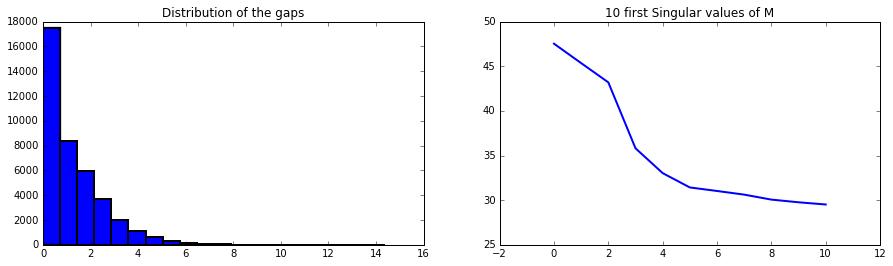

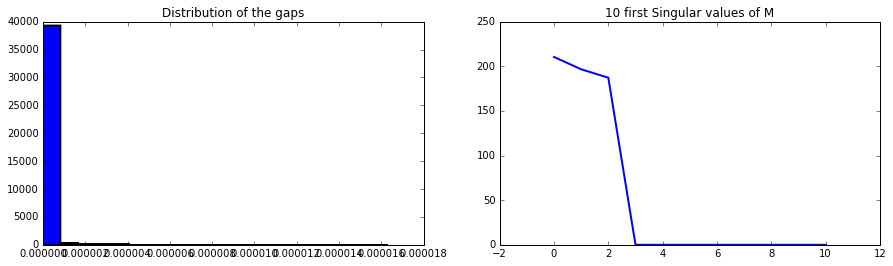

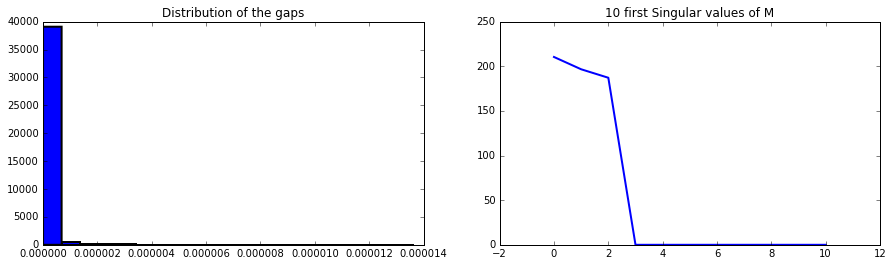

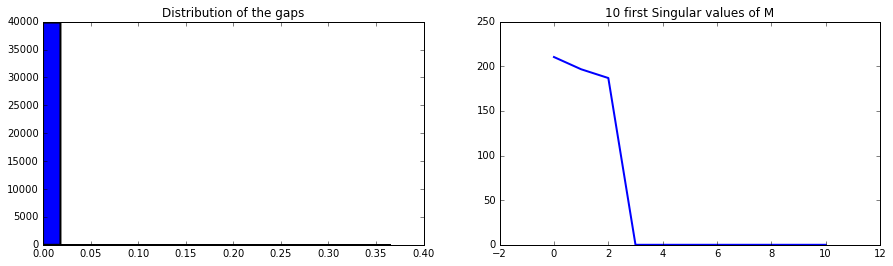

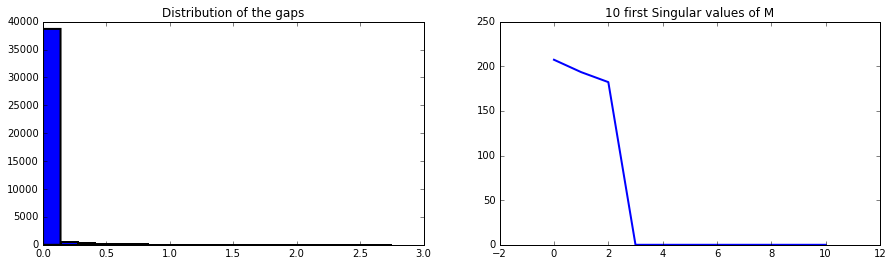

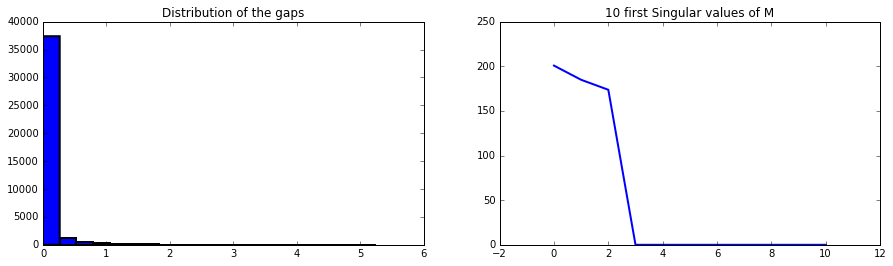

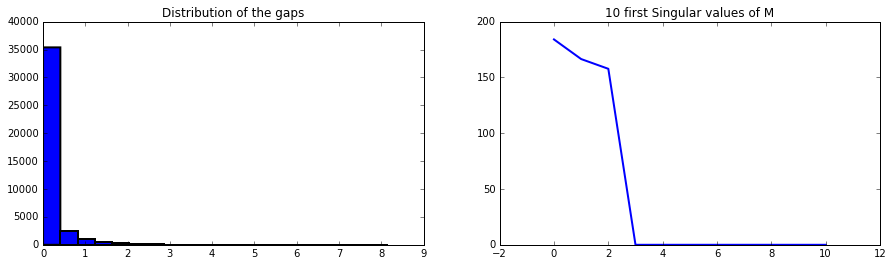

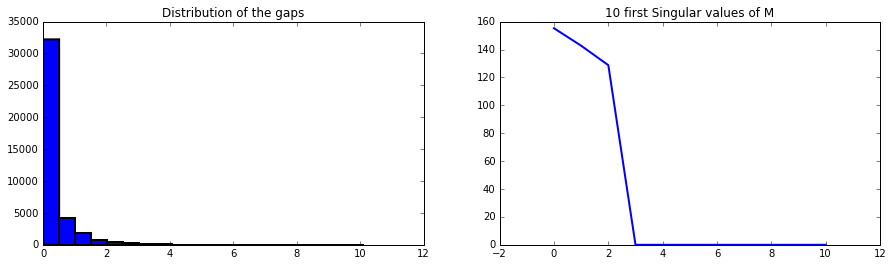

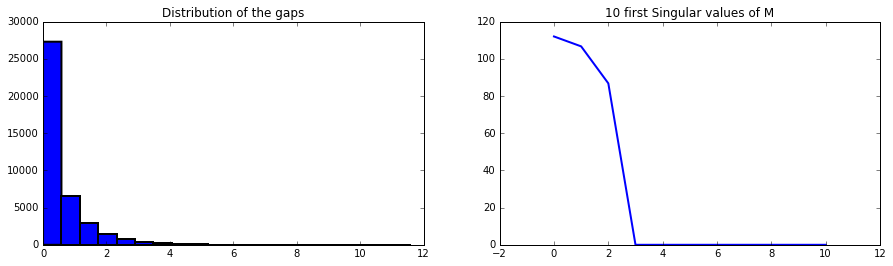

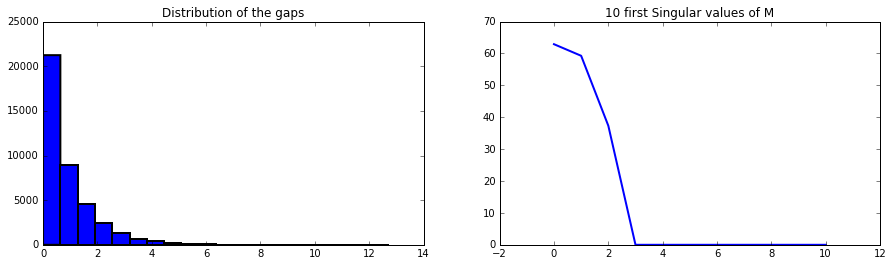

In [90]:
for mu in np.arange(10):
    M,N,U,k = QuantileMatCompletionADMM(Yobs1, indices1, m1,m2, tau=.5, mu=mu, rho=.2, tol=.00001, itermax=2000)
    print(mu, k)
    print(SquaredLossTest(Yobs1,M,indices1), SquaredLossTot(Y1,M), AbsLossTest(Yobs1,M,indices1), AbsLossTot(Y1,M))
    print("The Nuclear norm is: ", sum(np.linalg.svd(M)[1]))
    plt.figure(figsize=(15,4))
    plt.subplot(1,2,1)
    plt.hist(abs(np.reshape(Y1-M,m1*m2,1)), 20, lw=2)
    plt.title("Distribution of the gaps")
    plt.subplot(1,2,2)
    plt.plot(np.linalg.svd(M)[1][0:11], lw=2)
    plt.title("10 first Singular values of M")
    plt.xlim([-2, 12])

Second Test: different values for $\mu$ with large $\rho$ (=1). The solutions are always perfect, strange behavior of the algorithm. 

In [ ]:
for mu in np.arange(10):
    M,N,U,k = QuantileMatCompletionADMM(Yobs1, indices1, m1,m2, tau=.5, mu=mu, rho=1, tol=.00001, itermax=2000)
    print(mu, k)
    print(SquaredLossTest(Yobs1,M,indices1), SquaredLossTot(Y1,M), AbsLossTest(Yobs1,M,indices1), AbsLossTot(Y1,M))
    print("The Nuclear norm is: ", sum(np.linalg.svd(M)[1]))
    plt.figure(figsize=(15,4))
    plt.subplot(1,2,1)
    plt.hist(abs(np.reshape(Y1-M,m1*m2,1)), 20, lw=2)
    plt.title("Distribution of the gaps")
    plt.subplot(1,2,2)
    plt.plot(np.linalg.svd(M)[1][0:11], lw=2)
    plt.title("10 first Singular values of M")
    plt.xlim([-2, 12])

### Section 2.2.2: Test with small level of noise

In [91]:
[Y11,Yobs11,indices11]=AbsMatrixCreationA(m1,m2,rank,n,0.2)

Small value of $\rho$ (=0.2).

In [ ]:
for mu in np.arange(10):
    M,N,U,k = QuantileMatCompletionADMM(Yobs11, indices11, m1,m2, tau=.5, mu=mu, rho=.2, tol=.00001, itermax=2000)
    print(mu, k)
    print(SquaredLossTest(Yobs11,M,indices11), SquaredLossTot(Y11,M), AbsLossTest(Yobs11,M,indices11), AbsLossTot(Y11,M))
    print("The Nuclear norm is: ", sum(np.linalg.svd(M)[1]))
    plt.figure(figsize=(15,4))
    plt.subplot(1,2,1)
    plt.hist(abs(np.reshape(Y11-M,m1*m2,1)), 20, lw=2)
    plt.title("Distribution of the gaps")
    plt.subplot(1,2,2)
    plt.plot(np.linalg.svd(M)[1][0:11], lw=2)
    plt.title("10 first Singular values of M")
    plt.xlim([-2, 12])

large value of $\rho$ (=1)

In [ ]:
for mu in np.arange(10):
    M,N,U,k = QuantileMatCompletionADMM(Yobs11, indices11, m1,m2, tau=.5, mu=mu, rho=1, tol=.00001, itermax=2000)
    print(mu, k)
    print(SquaredLossTest(Yobs11,M,indices11), SquaredLossTot(Y11,M), AbsLossTest(Yobs11,M,indices11), AbsLossTot(Y11,M))
    print("The Nuclear norm is: ", sum(np.linalg.svd(M)[1]))
    plt.figure(figsize=(15,4))
    plt.subplot(1,2,1)
    plt.hist(abs(np.reshape(Y11-M,m1*m2,1)), 20, lw=2)
    plt.title("Distribution of the gaps")
    plt.subplot(1,2,2)
    plt.plot(np.linalg.svd(M)[1][0:11], lw=2)
    plt.title("10 first Singular values of M")
    plt.xlim([-2, 12])

For a fixed $\mu$, study of the effect of $\rho$

In [ ]:
for rho in np.arange(10):
    M,N,U,k = QuantileMatCompletionADMM(Yobs11, indices11, m1,m2, tau=.5, mu=3, rho=(rho*2+1.)/10, tol=.00001, itermax=2000)
    print(rho, k)
    print(SquaredLossTest(Yobs11,M,indices11), SquaredLossTot(Y11,M), AbsLossTest(Yobs11,M,indices11), AbsLossTot(Y11,M))
    print("The Nuclear norm is: ", sum(np.linalg.svd(M)[1]))

## Section 2.3 : Fast SVD

We use the topo from https://jakevdp.github.io/blog/2012/12/19/sparse-svds-in-python/
The first attempt uses ARPACK, a set of Fortran subroutines. PROPACK is not useful to our case because it only suits sparse matrices (in Fortran). The big issue here is that the method "svds", called by TruncatedSVD is only suitable for sparse matrices in Python. It's not a Fortran issue. However, it works on regular matrices so we use this version.
Another method in order to compute approximated SVD is to use randomized version.

In [12]:
[Y5,Yobs5,indices5]=AbsMatrixCreationA(3000,3000,10,n,0.2) # The difference is enough impressive


In [10]:
U, Sigma, VT = svds(Y5, k=20) ; Sigma

array([ 2810.71206556,  2924.71410333,  2943.14261837,  2958.38116791,
        2978.56525181,  3020.24047066,  3043.82189401,  3066.0155669 ,
        3099.76474729,  3183.76825908,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ])

In [11]:
U, Sigma, V = np.linalg.svd(Y5); Sigma[0:20]

array([  3.18376826e+03,   3.09976475e+03,   3.06601557e+03,
         3.04382189e+03,   3.02024047e+03,   2.97856525e+03,
         2.95838117e+03,   2.94314262e+03,   2.92471410e+03,
         2.81071207e+03,   4.76269673e-12,   4.37701146e-12,
         3.87380262e-12,   3.18430707e-12,   2.82775426e-12,
         2.66483292e-12,   2.49625455e-12,   2.43198955e-12,
         2.42106775e-12,   2.36752491e-12])

New Method in order to use Truncated SVD. The new parameter "l" is the size of the increment for computing the first k then k+l largest singular values.

In [133]:
def Fast_QuantileMatCompletionADMM(Yobs, indices, m1,m2, tau, mu, rho,tol,itermax=1000, init_k=10, increment=5):
    n = len(Yobs)
    M = np.random.normal(0,1,size=(m1,m2))
    N = np.zeros((m1,m2))
    U = np.zeros((m1,m2))
    
    # All the variables to float type:
    mu = float(mu) ; rho = float(rho)
    
    if n != len(indices): print("There is a big Problem, check Yobs and indices")
    
    # function to evaluate the minimum of:
    # tau(y-x)_+ + (1-tau)(x-y)_+ + r/2(x-b)^2
    # w.r.t x
        
    def min_abs(y,b):
        x1 = np.minimum(y,b+tau/rho)
        x2 = np.maximum(y,b-(1-tau)/rho)
        y1 = tau*(y-x1) + rho/2 * (x1-b)**2
        y2 = (1-tau)*(x2-y) + rho/2*(x2-b)**2
        ind_min = np.where(y1<y2,x1,x2)
        return(ind_min)
    
    def update_M(N,U):
        M = N-U
        b = M.flat[indices]
        M.flat[indices] = min_abs(Yobs,b)
        return(M)
    
    def FastSoftThresMat(A,x):
        min_SV = float("inf")
        K=init_k
        while min_SV > x:
            u,S,v = svds(A,k=K)
            K = K + increment
            min_SV = S[0] 
            ## Be careful, reverse order for svds !!!

        j = S <= x
        S[j] = 0
        j = S > x
        S[j] = S[j] - x
        l=sum(j)
        # Reverse order:
        u = u[:,::-1]
        S = S[::-1]
        v = v[::-1,:]
        return(np.dot(u[:,:l],np.dot(np.diag(S[:l]),v[:l,:])))
    
    def update_N(M,U):
        return(FastSoftThresMat(M+U,mu/rho))
        
    def update_U(M,N,U):
        return(U + M -N)
    
    # Main Loop
    
    ec = 1000.
    k = 0
    while(ec>tol and k<itermax):
        k = k+1
        oldM = M
        oldU = U
        # Order is arbitrary, we use this order because of the nullity of many coefficients of U.
        N = update_N(M,U)
        M = update_M(N,U)
        U = update_U(M,N,U)
        
        ecM = np.max(abs(M-oldM))
        ecU = np.max(abs(U-oldU))
        ec=ecM+ecU
        
    return(M,N,U,k)

In [125]:
M,N,U,k = QuantileMatCompletionADMM(Yobs11, indices11, m1,m2, tau=.5, mu=4, rho=.2, tol=.00001, itermax=2000)

In [134]:
M,N,U,k = Fast_QuantileMatCompletionADMM(Yobs11, indices11, m1,m2, tau=.5, mu=4, rho=.2,tol=.00001,itermax=2000, init_k=10, increment=5)

In [98]:
import time
startTime = time.time()
M,N,U,k = QuantileMatCompletionADMM(Yobs11, indices11, m1,m2, tau=.5, mu=4, rho=.2, tol=.00001, itermax=2000)
elapsedTime = time.time() - startTime
print(elapsedTime)

3.21447706223


In [100]:
startTime = time.time()
M,N,U,k = Fast_QuantileMatCompletionADMM(Yobs11, indices11, m1,m2, tau=.5, mu=4, rho=.2,tol=.00001,itermax=2000, init_k=10, increment=5)
elapsedTime = time.time() - startTime
print(elapsedTime)

18.3150880337


/home/vincentpro/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/vincentpro/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(0, 61)
(1.254816226785634, 3.7811812821572204, 0.49823666328804656, 1.4730747973781984)
('The Nuclear norm is: ', 16767.835424108751)
(1, 668)
(1.2197910419607287, 1.2937134966258046, 0.5175691556371228, 0.89754424865629412)
('The Nuclear norm is: ', 10433.612104273421)
(2, 470)
(1.5220731050928744, 0.40652372673241516, 0.84650583753844277, 0.50826358765106017)
('The Nuclear norm is: ', 4854.1482579267522)
(3, 579)
(2.1895389203183511, 0.29244388108010866, 1.1634994250017947, 0.41010368685262155)
('The Nuclear norm is: ', 2044.3531451365602)
(4, 684)
(2.4065384341702711, 0.49036265602957663, 1.222183889151393, 0.52465168878966184)
('The Nuclear norm is: ', 1788.7958304943047)
(5, 664)
(2.756846709734198, 0.83750527478112768, 1.3052841422636161, 0.67767202543555582)
('The Nuclear norm is: ', 1527.9147775827569)
(6, 588)
(3.3574037957552485, 1.4322866110675878, 1.4337450370375271, 0.88042208351344031)
('The Nuclear norm is: ', 1200.8512955748324)
(7, 541)
(4.3685201561360545, 2.42690802

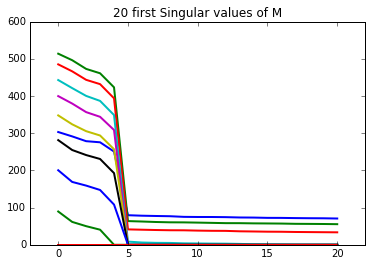

In [137]:
## Test on larger matrices
[Y5,Yobs5,indices5]=AbsMatrixCreationA(500,500,5,1000*1000*.2,2) 
for mu in np.arange(10):
    M,N,U,k = QuantileMatCompletionADMM(Yobs5, indices5, m1=500,m2=500, tau=.5, mu=mu*5, rho=2, tol=.00001, itermax=1000)
    print(mu, k)
    print(SquaredLossTest(Yobs5,M,indices5), SquaredLossTot(Y5,M), AbsLossTest(Yobs5,M,indices5), AbsLossTot(Y5,M))
    print("The Nuclear norm is: ", sum(np.linalg.svd(M)[1]))
    plt.plot(np.linalg.svd(M)[1][0:21], lw=2)
    plt.title("20 first Singular values of M")
    plt.xlim([-2, 22])

In [139]:
startTime = time.time()
M,N,U,k = QuantileMatCompletionADMM(Yobs5, indices5, m1=500,m2=500, tau=.5, mu=15, rho=2, tol=.00001, itermax=1000)
print(mu, k)
print(SquaredLossTest(Yobs5,M,indices5), SquaredLossTot(Y5,M), AbsLossTest(Yobs5,M,indices5), AbsLossTot(Y5,M))
elapsedTime = time.time() - startTime
print(elapsedTime)

(9, 579)
(2.1895389355841699, 0.29244389801163684, 1.1634994285393603, 0.41010369701054922)
52.8472049236


In [143]:
startTime = time.time()
M2,N,U,k = Fast_QuantileMatCompletionADMM(Yobs5, indices5, m1=500,m2=500, tau=.5, mu=15, rho=2,tol=.00001,itermax=1000, init_k=20, increment=10)
print(mu, k)
print(SquaredLossTest(Yobs5,M2,indices5), SquaredLossTot(Y5,M2), AbsLossTest(Yobs5,M2,indices5), AbsLossTot(Y5,M2))
elapsedTime = time.time() - startTime
print(elapsedTime)

(9, 578)
(2.189538996992336, 0.29244395691752806, 1.1634994449034584, 0.41010373511521681)
40.6920361519


In [142]:
svds(M2,k=30)[1]

array([  1.22650578e-01,   6.62169547e-01,   1.04951415e+00,
         1.40598444e+00,   2.38001292e+00,   3.01595790e+00,
         3.23122104e+00,   3.61151962e+00,   3.92804621e+00,
         5.02955204e+00,   5.26434929e+00,   6.13922810e+00,
         8.55450157e+00,   3.48780807e+02,   3.86811920e+02,
         4.00279189e+02,   4.21216629e+02,   4.42869148e+02,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00])